In [24]:
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import networkx as nx
import sys
import pickle 
import math
from itertools import chain, combinations

In [25]:
def get_user_info():
    """
    load stored user info, list of dicts
    (screen_name, id, friend_id)
    """
    with open('information.pkl', 'rb') as f:
        return pickle.load(f)

In [26]:
def print_num_friends(users):
    """
    Print the number of friends of each user, sorted by candidate name.
    
    Args:
        users....The list of user dicts.
    Returns:
        Nothing
    """  
    for u in users:
        a = str(len(u['friend_id']))
        print(u['screen_name'] + ' ' + a)

In [27]:
def count_friends(users):
    """
    Count how often each friend is followed.
    
    Args:
        users: a list of user dicts
    Returns:
        a Counter object mapping each friend to the number of candidates who follow them.
        Counter documentation: https://docs.python.org/dev/library/collections.html#collections.Counter
    """
    c = Counter()
    friends = []
    for user in users:
        #list of friends of each user
        friends.append(user['friend_id'])
    for friend in friends:
        #count each friend in friends[] and update the counter
        c.update(friend)
    return c

In [28]:
def friend_overlap(users):
    """
    Compute the number of common friends of each pair of users.
    Args:
        users...The list of user dicts.
    Return:
        A list of tuples containing (user1, user2, N), where N is the
        number of friends that both user1 and user2 follow.
        This list shouldbe sorted in descending order of N.
        Ties are broken first by user1's screen_name, then by
        user2's screen_name (sorted in ascending alphabetical order).
    """
    l = []
    t =  ()
    for i in range(len(users)):
        for j in range(len(users)):
            if i == j:
                continue   
            else:
                # print(str(set(users[i]['friends']) & set(users[j]['friends'])))
                x = (set(users[i]['friend_id']) & set(users[j]['friend_id']))
                if str(users[i]['screen_name']) < str(users[j]['screen_name']):
                    l.append((users[i]['screen_name'], users[j]['screen_name'], len(x)))
                else:
                    l.append((users[j]['screen_name'], users[i]['screen_name'], len(x)))
                l = list(set(l))
                #print(str(l))
                l = sorted(l, key = lambda x: x[1])
                l = sorted(l, key = lambda x: x[0])
                l = sorted(l, key = lambda x: -x[2])
    return l

In [29]:
def create_graph(users, friend_counts, min_common):
    """
    Create a networkx undirected Graph, adding each user and their friends
    as a node.
    Note: while all users should be added to the graph,
    Each user in the Graph will be represented by their screen_name,
    while each friend will be represented by their user id.
    Args:
      users...........The list of user dicts.
      friend_counts...The Counter dict mapping each friend to the number of candidates that follow them.
      min_common......Add friends to the graph if they are followed by more than min_common users.
    Returns:
      A networkx Graph
    """

#     #list of friends ids followed by more than min_common users
#     friends = [x for x in friend_counts if friend_counts[x] > min_common]
    
#     #draw undirected graph
#     graph = nx.Graph()
#     #add nodes for friends
#     for x in friends:
#         graph.add_node(x)
#     #add users nodes
#     for user in users:
#         graph.add_node(user['id'])
#         #list of friends should be plotted
#         fndlst = set(user['friend_id']) & set(friends)
#         #add edges for each node
#         for fnd in fndlst:
#             graph.add_edge(fnd, user['id'])

#     nx.draw_networkx(graph, with_labels=True)
    
#     return graph

    graph = nx.Graph()
    for user in users:
        graph.add_node(user['screen_name']) 
        for friend in user['friend_id']:
            if(friend_counts[friend] > 1):
                graph.add_node(friend)  
                graph.add_edge(user['screen_name'], friend)  
#     nx.draw(graph, with_labels = True)
    return graph

In [30]:
def draw_network(graph, users, filename):
    """
    Draw the network to a file.
    Only label the candidate nodes; the friend
    nodes should have no labels (to reduce clutter).
    params:
        graph...........the undirected graph created
        users...........list of dicts
        filename........the name of the saved network figure
    """
#     label = {}
#     for n in graph.nodes():
#         for u in users:
#             if n in u['id']:
#                 label[n] = u['screen_name']
    
#     plt.figure(figsize=(15, 15))
#     plt.axis('off')

#     nx.draw_networkx(graph, labels=label, alpha=.5, node_size=50, width=.5)
#     plt.savefig(filename)
    
    pos = nx.spring_layout(graph)
    label = {}
    l = []
    for user in users:
        l.append(user['screen_name'])
    for node in l:
        label[node] = node
    plt.figure(figsize=(15,15),dpi=50)
#     nx.draw_networkx(graph, pos=pos,labels=label,node_size=80,alpha=0.5,width=0.1,font_size=20)
    nx.draw_networkx(graph, pos, node_size = 80, alpha = 0.5, labels = label, width = 0.1, font_size = 20)
    plt.axis('off')
    plt.savefig(filename, format = 'PNG')
    plt.show()

In [31]:
def get_subgraph(graph, min_degree):
    """
    Return a subgraph containing nodes whose degree is
    greater than or equal to min_degree.
    To prune the original graph.
    Params:
      graph........a networkx graph
      min_degree...degree threshold
    Returns:
      a networkx graph, filtered as defined above.
    """
    
    sub_nodes = []
    node_list = graph.nodes()
    for node in node_list:
        if graph.degree(node) >= min_degree:
            sub_nodes.append(node)
    subgraph = graph.subgraph(sub_nodes)

    return subgraph

In [32]:
def bfs(graph, root, max_depth):
    """
    Perform breadth-first search to compute the shortest paths from a root node to all
    other nodes in the graph. To reduce running time, the max_depth parameter ends
    the search after the specified depth.
    Params:
      graph.......A networkx Graph
      root........The root node in the search graph (a string). We are computing
                  shortest paths from this node to all others.
      max_depth...An integer representing the maximum depth to search.
    Returns:
      node2distances...dict from each node to the length of the shortest path from
                       the root node
      node2num_paths...dict from each node to the number of shortest paths from the
                       root node that pass through this node.
      node2parents.....dict from each node to the list of its parents in the search
                       tree
    """
    node2distances = {}
    node2num_paths = {}
    node2parents = {}
    visiting = deque([])
    visited = deque([])

    #init root
    node2distances[root] = 0
    node2num_paths[root] = 1
    visiting.append(root)
    visited.append(root)

    #compute each node from root
    while len(visiting) != 0:
        current = visiting.popleft()
        visited.append(current)
        #if exceed max_depth, do not include
        if node2distances[current] >= max_depth:
            break
        else:
            for n in graph.neighbors(current):
                if not (n in visited):
                    #new leaf
                    if not (n in visiting):
                        node2distances[n] = node2distances[current] + 1
                        node2parents[n] = [current]
                        node2num_paths[n] = len(node2parents[n])
                        visiting.append(n)
                    #leaf computed
                    elif n in visiting and node2distances[n] != node2distances[current]:
                        node2parents[n].append(current)
                        node2num_paths[n] = len(node2parents[n])

    return node2distances, node2num_paths, node2parents

In [33]:
def bottom_up(root, node2distances, node2num_paths, node2parents):
    """
    Compute the final step of the Girvan-Newman algorithm.
    Params:
      root.............The root node in the search graph (a string). We are computing
                       shortest paths from this node to all others.
      node2distances...dict from each node to the length of the shortest path from
                       the root node
      node2num_paths...dict from each node to the number of shortest paths from the
                       root node that pass through this node.
      node2parents.....dict from each node to the list of its parents in the search
                       tree
    Returns:
      A dict mapping edges to credit value. Each key is a tuple of two strings
      representing an edge (e.g., ('A', 'B')).
    """
    nodecredit = defaultdict(float)
    edgecredit = defaultdict(float)
    
    for key in node2distances.keys():
        if key != root:
            nodecredit[key] = 1.0
        else:
            nodecredit[root] = 0.0
            
    sort = sorted(node2distances.items(), key=lambda x: (-x[1]))
    
    for key, value in sort:
        if key != root:
            parent = node2parents[key]
            num_parent = len(parent)
            if num_parent == 0:
                break
            if num_parent == 1:
                nodecredit[parent[0]] = nodecredit[parent[0]] + nodecredit[key]
                edge = tuple(sorted([key, parent[0]]))
                edgecredit[edge] = nodecredit[key]
            else:
                edge_credit = nodecredit[key]/num_parent
                for p in parent:
                    nodecredit[p] = nodecredit[p] + edge_credit
                    edge = tuple(sorted([key, p]))
                    edgecredit[edge] = edge_credit
    
    return dict(sorted(edgecredit.items()))

In [34]:
def approximate_betweenness(graph, max_depth):
    """
    Compute the approximate betweenness of each edge, using max_depth to reduce
    computation time in breadth-first search.
    Only leave the original users nodes and corresponding edges and betweenness for future analysis.
    Params:
      graph.......A networkx Graph
      max_depth...An integer representing the maximum depth to search.
    Returns:
      A dict mapping edges to betweenness. Each key is a tuple of two strings
      representing an edge (e.g., ('A', 'B')). Make sure each of these tuples
      are sorted alphabetically (so, it's ('A', 'B'), not ('B', 'A')).
    """
    edgecredit = defaultdict(float)
    betweenness = defaultdict(float)
    
    for node in graph.nodes():
        node2distances, node2num_paths, node2parents = bfs(graph, node, max_depth)
        result = bottom_up(node, node2distances, node2num_paths, node2parents)
        
        for key, value in result.items():
            edgecredit[key] += value
        
    for key, value in edgecredit.items():
        betweenness[key] = edgecredit[key]/ 2.0   
    return dict(sorted(betweenness.items()))

In [59]:
def partition_girvan_newman(graph, max_depth, num_clusters):
    """
    Use the approximate_betweenness implementation to partition a graph.
    Unlike in class, here you will not implement this recursively. Instead,
    just remove edges until more than one component is created, then return
    those components.
    That is, compute the approximate betweenness of all edges, and remove
    them until multiple comonents are created.
    Note: the original graph variable should not be modified. Instead,
    make a copy of the original graph prior to removing edges.
    Params:
      graph..........A networkx Graph created before
      max_depth......An integer representing the maximum depth to search.
      num_clusters...number of clusters want
    Returns:
      clusters...........A list of networkx Graph objects, one per partition.
      users_graph........the partitioned users graph.
    """
    clusters = []

    partition_edge = list(sorted(approximate_betweenness(graph, max_depth).items(), key=lambda x:(-x[1], x[0])))
    
    for i in range(0, len(partition_edge)):
        graph.remove_edge(*partition_edge[i][0])
        clusters = list(nx.connected_component_subgraphs(graph))
        if len(clusters) >= num_clusters:
            break

    #remove outliers
    new_clusters = [cluster for cluster in clusters if len(cluster.nodes()) > 1]

    return new_clusters, graph

In [60]:
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

users info got.
Number of friends of each user:
satyanadella 229
JeffBezos 1
sundarpichai 332
jack 3874
Most common friends:
[('10078', 3), ('11348282', 3), ('14225267', 3), ('14600116', 3), ('15076390', 3)]
Friend Overlap:
[('jack', 'sundarpichai', 141), ('jack', 'satyanadella', 70), ('satyanadella', 'sundarpichai', 37), ('JeffBezos', 'jack', 1), ('JeffBezos', 'satyanadella', 0), ('JeffBezos', 'sundarpichai', 0)]
graph has 193 nodes and 408 edges


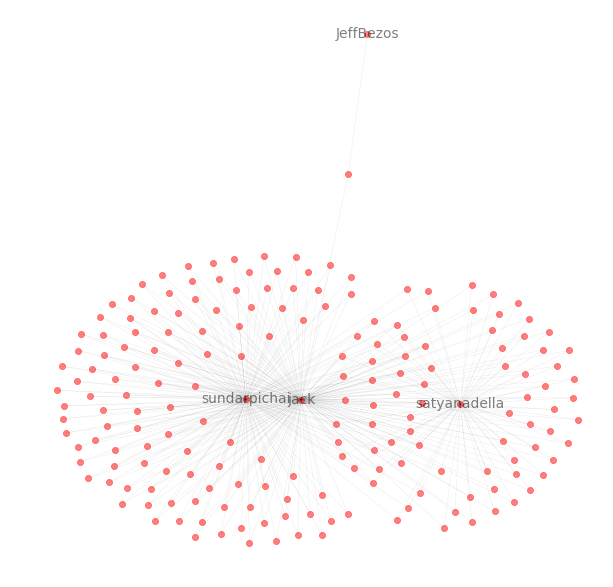

network drawn to original.png
subgraph has 193 nodes and 408 edges


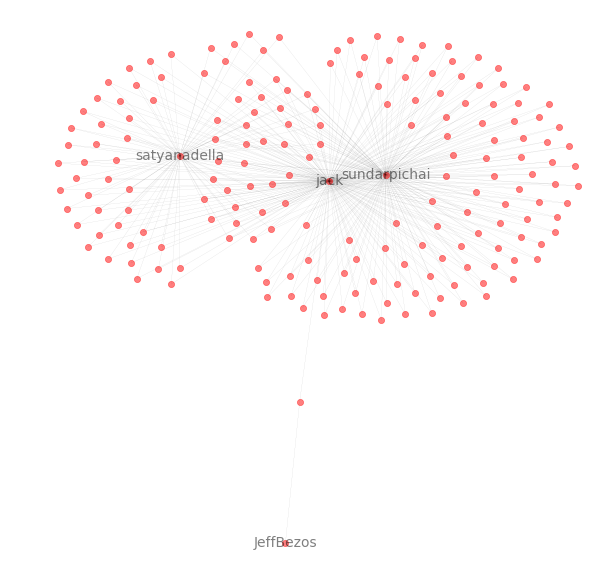

network drawn to pruned.png


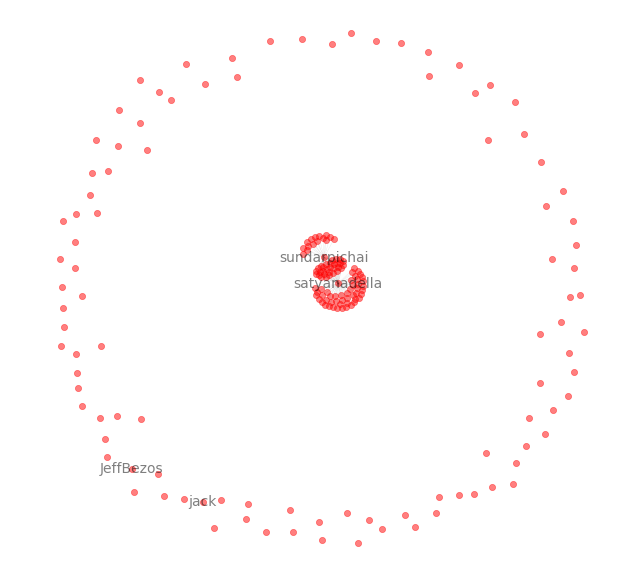

network drawn to clusters.png
1


In [61]:
def main():
    users = get_user_info()
    print("users info got.")
    print('Number of friends of each user:')
    print_num_friends(users)
    friend_counts = count_friends(users)
    print('Most common friends:\n%s' % str(friend_counts.most_common(5)))
    print('Friend Overlap:\n%s' % str(friend_overlap(users)))
    
    graph = create_graph(users, friend_counts, 0)
    print('graph has %s nodes and %s edges' % (len(graph.nodes()), len(graph.edges())))
    draw_network(graph, users, 'original.png')
    print('network drawn to original.png')

    subgraph = create_graph(users, friend_counts, 1)
    print('subgraph has %s nodes and %s edges' % (len(subgraph.nodes()), len(subgraph.edges())))
    draw_network(subgraph, users, 'pruned.png')
    print('network drawn to pruned.png')
    
    clusters, partitioned_graph = partition_girvan_newman(subgraph, 5, 100)

    save_obj(clusters, 'clusters')
    draw_network(partitioned_graph, users, 'clusters.png')
    print('network drawn to clusters.png')
#     print(len(clusters))

if __name__ == '__main__':
    main()